In [1]:
%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np
import datetime
import scipy.linalg as linalg
from copy import copy

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.quantum_info import Operator
from qiskit.compiler import transpile
from qiskit.providers.aer.noise import NoiseModel

from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram, plot_gate_map, plot_circuit_layout

import kmeans_qaoa as kq

# Generate a sample problem instance
We can define our own coreset or use a default randomly generated one

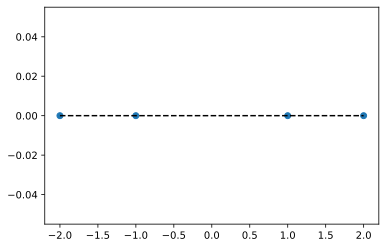

The corresponding problem Hamiltonian is:
H = 2.0ZZII + -2.0ZIZI + -4.0ZIIZ + -1.0IZZI + -2.0IZIZ + 2.0IIZZ 


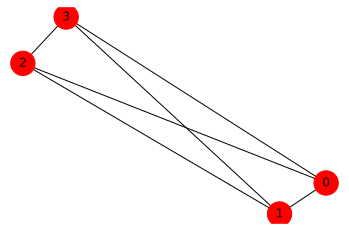

In [3]:
coreset = [(1, np.array([-2,0])), (1, np.array([-1,0])), (1, np.array([1,0])), (1, np.array([2,0]))]
#coreset = None
coreset_points, G, H = kq.gen_coreset_graph(coreset=coreset, metric='dot')
#coreset_points2, G_dist, H2 = kq.gen_coreset_graph(coreset=coreset, metric='dist')
kq.plot_coreset_graph(coreset_points, G)
hstr = ''
for term in H:
    hstr += '{:.1f}{} + '.format(term[0], ''.join(term[1]))
hstr = hstr[:-2]
print('The corresponding problem Hamiltonian is:\nH = {}'.format(hstr))

OrderedDict([('cx', 12), ('rz', 6), ('h', 4), ('rx', 4), ('measure', 4), ('barrier', 3)])


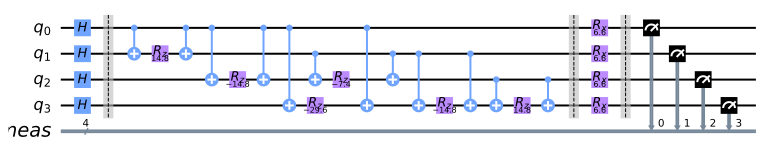

In [5]:
mycirc = kq.gen_complete_qaoa_circ(1, [3.7], [3.3], G)
print(mycirc.count_ops())
mycirc.draw(output='mpl', scale=0.4, fold=180)

OrderedDict([('cx', 17), ('rz', 6), ('h', 4), ('rx', 4), ('measure', 4), ('barrier', 3)])


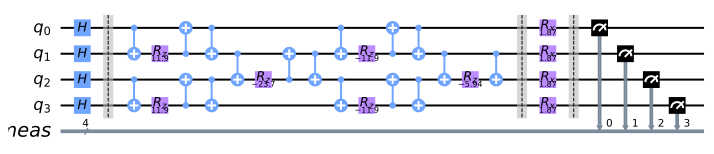

In [6]:
device_topology = [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]
mycirc, _ = kq.gen_complete_qaoa_circ(1, [2.96867277], [0.93459749], G, topology=device_topology)
print(mycirc.count_ops())
mycirc.draw(output='mpl', scale=0.4, fold=180)

OrderedDict([('u1', 12), ('cu1', 6), ('h', 4), ('rx', 4), ('measure', 4), ('barrier', 3)])


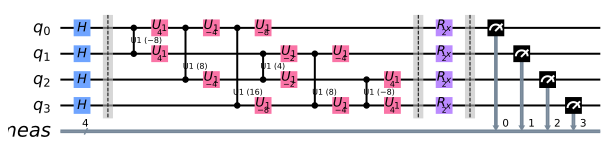

In [5]:
mycirc = kq.gen_complete_qaoa_circ(1, [1], [1], G, ising=True)
print(mycirc.count_ops())
mycirc.draw(output='mpl', scale=0.4, fold=180)

# Run QAOA on QASM simulator

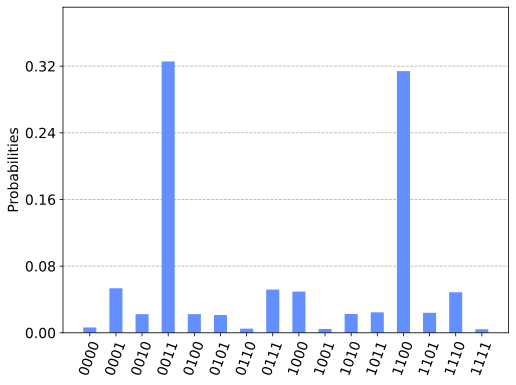

In [7]:
# run on local simulator
backend = Aer.get_backend("qasm_simulator")
shots = 10000

simulate = execute(mycirc, backend=backend, shots=shots)
raw_counts = simulate.result().get_counts()

counts = kq.reorder_bitstrings(1, len(G.nodes), copy(raw_counts))

plot_histogram(counts,figsize = (8,6),bar_labels = False)

partition: [0, 1, 0, 1], cost: -3, counts: 213
partition: [0, 0, 1, 0], cost: -3, counts: 224
partition: [1, 1, 1, 0], cost: 3, counts: 486
partition: [0, 1, 0, 0], cost: -3, counts: 224
partition: [1, 1, 0, 1], cost: -3, counts: 240
partition: [0, 1, 1, 0], cost: -5, counts: 49
partition: [1, 0, 1, 0], cost: -3, counts: 225
partition: [1, 1, 1, 1], cost: -5, counts: 42
partition: [1, 0, 1, 1], cost: -3, counts: 245
partition: [1, 1, 0, 0], cost: 13, counts: 3140
partition: [0, 0, 1, 1], cost: 13, counts: 3256
partition: [0, 0, 0, 0], cost: -5, counts: 64
partition: [1, 0, 0, 1], cost: -5, counts: 45
partition: [0, 0, 0, 1], cost: 3, counts: 534
partition: [0, 1, 1, 1], cost: 3, counts: 519
partition: [1, 0, 0, 0], cost: 3, counts: 494

 --- SIMULATION RESULTS ---

The sampled mean value is avg_C = 8.41

The approximate solution is x* = 1100 with C(x*) = 13 

The cost function is distributed as: 



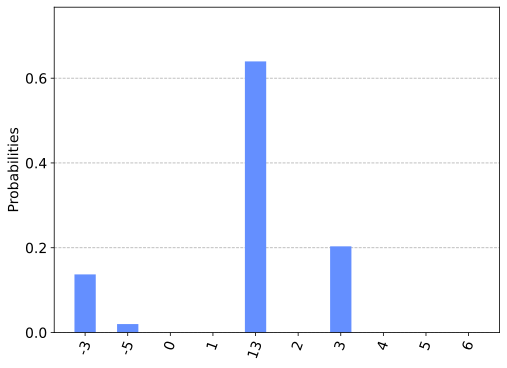

In [8]:
# Evaluate the data from the simulator
tot_C = 0
max_C = [0,0]
hist  = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x = [int(num) for num in list(sample)]
    tmp_eng = kq.cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    tot_C = tot_C + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    print('partition: {}, cost: {}, counts: {}'.format(x,tmp_eng, counts[sample]))
        
    # save best bit string
    if(max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
avg_C = tot_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is avg_C = %.02f\n' % (avg_C))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)

# Energy Landscape

In [9]:
# Noiseless sim, all-to-all connectivity
P = 1
step_size = 0.1
shots = 10000
gammaLim = [0,1.5*np.pi]
betaLim = [0,1.5*np.pi]
estC, bitstrings = kq.energy_landscape(P, step_size, shots, gammaLim, betaLim, G)

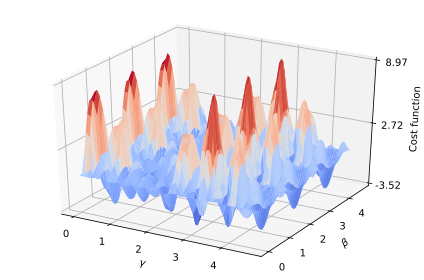


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value (avg over 10000 shots) is:  C = 8.966
This is attained for gamma = 0.500 and beta = 3.300
The 4 most common partitionings produced at this point were:
1011: 8.39% (-3), 1101: 8.31% (-3), 0100: 8.28% (-3), 0010: 7.56% (-3)
mu_plus: [0.33333333 0.        ]
mu_minus: [-1.  0.]


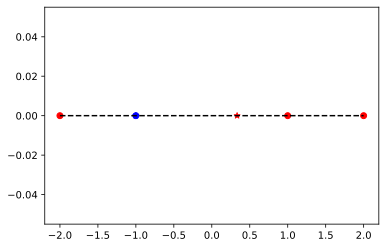

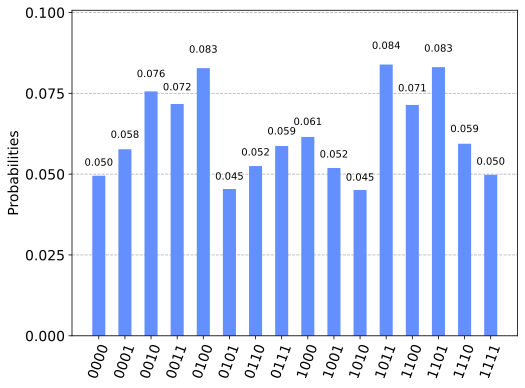

In [10]:
optimal_counts = kq.plot_energy_landscape(step_size, gammaLim, betaLim, estC, bitstrings, shots, coreset_points, G, savefigs='')
plot_histogram(optimal_counts, figsize=(8,6))

In [11]:
# Noiseless sim, linear connectivity -> swap network
P = 1
step_size = 0.1
shots = 10000
gammaLim = [0,1.5*np.pi]
betaLim = [0,1.5*np.pi]
device_topology = [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]
estC, bitstrings = kq.energy_landscape(P, step_size, shots, gammaLim, betaLim, G, device_topology=device_topology)

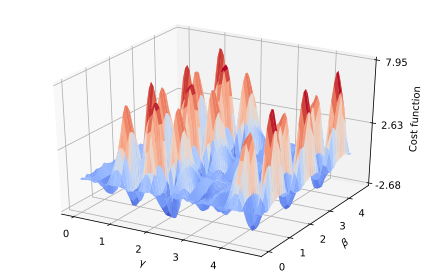


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value (avg over 10000 shots) is:  C = 7.945
This is attained for gamma = 1.000 and beta = 1.400
The 4 most common partitionings produced at this point were:
0000: 13.88% (-5), 0110: 13.85% (-5), 1111: 13.55% (-5), 1001: 13.41% (-5)
mu_plus: nan
mu_minus: [0. 0.]


/Users/teague/ResearchWorkspace/coresets/kmeans_qaoa.py:470: RuntimeWarning: invalid value encountered in double_scalars
  mu_plus = np.sum([point[0]*point[1] for point in S_plus], axis=0) / np.sum([point[0] for point in S_plus])


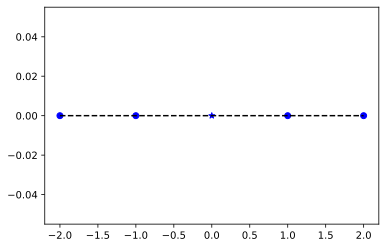

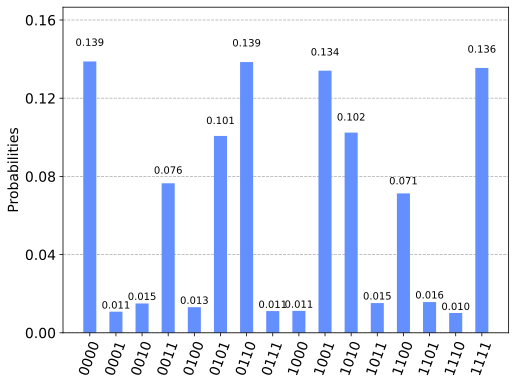

In [12]:
opt_counts = kq.plot_energy_landscape(step_size, gammaLim, betaLim, estC, bitstrings, shots, coreset_points, G, savefigs='')
plot_histogram(opt_counts, figsize=(8,6))

In [16]:
# Noiseless sim, linear connectivity -> swap network
# Using the distance metric graph
P = 1
step_size = 0.1
shots = 10000
gammaLim = [0,np.pi]
betaLim = [0,np.pi]
device_topology = [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]
estC, bitstrings = kq.energy_landscape(P, step_size, shots, gammaLim, betaLim, G_dist, device_topology=device_topology)

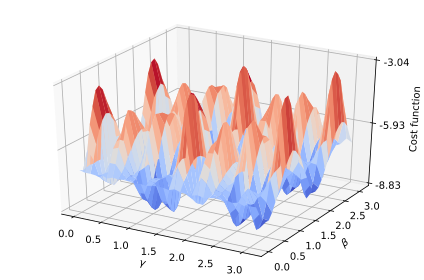


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value (avg over 10000 shots) is:  C = -3.039
This is attained for gamma = 1.100 and beta = 3.000
The 4 most common partitionings produced at this point were:
1010: 11.19% (-8.0), 0101: 10.95% (-8.0), 1101: 9.64% (-6.0), 1011: 9.34% (-6.0)
mu_plus: [-0.5  0. ]
mu_minus: [0.5 0. ]


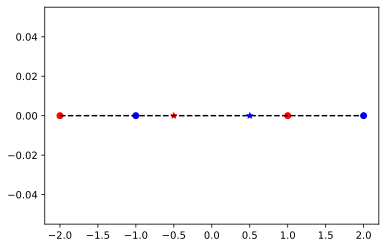

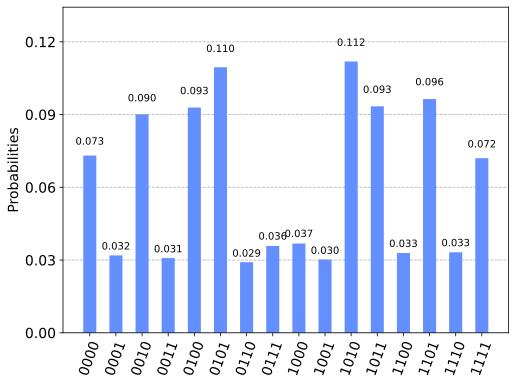

In [24]:
opt_counts = kq.plot_energy_landscape(step_size, gammaLim, betaLim, estC, bitstrings, shots, coreset_points, G_dist, savefigs='')
plot_histogram(opt_counts, figsize=(8,6))

# Map to device

In [4]:
provider = IBMQ.load_account()

In [14]:
backends = provider.backends()
for b in backends: print(b)

ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_vigo
ibmq_ourense
ibmq_london
ibmq_burlington
ibmq_essex
ibmq_armonk
ibmq_rome


In [15]:
for backend in backends:
    print(backend.name())
    config = backend.configuration()
    #print(backend.status())
    print(config.n_qubits, config.simulator, config.open_pulse, config.memory)
    #print(config.coupling_map)
    cmap = nx.Graph()
    if config.coupling_map is not None:
        cmap.add_edges_from(config.coupling_map)
        #nx.draw(cmap)
        #plt.show()

ibmq_qasm_simulator
32 True False True
ibmqx2
5 False False True
ibmq_16_melbourne
15 False False True
ibmq_vigo
5 False False True
ibmq_ourense
5 False False True
ibmq_london
5 False False True
ibmq_burlington
5 False False True
ibmq_essex
5 False False True
ibmq_armonk
1 False True True
ibmq_rome
5 False False True


## IBMQ Rome

<class 'qiskit.providers.ibmq.ibmqbackend.IBMQBackend'>
[[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]


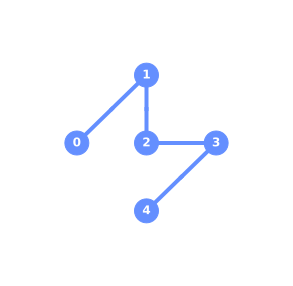

In [13]:
rome = provider.get_backend('ibmq_rome')
qasm_simulator = provider.get_backend('ibmq_qasm_simulator')
print(type(rome))
print(rome.configuration().coupling_map)
plot_gate_map(rome)

In [17]:
from qiskit.providers.ibmq.ibmqbackend import IBMQBackend
assert isinstance(rome, IBMQBackend), 'nope!'

### Compile the cnot circuit to Rome

Depth: 18
Gates: OrderedDict([('cx', 17), ('rz', 6), ('h', 4), ('rx', 4), ('measure', 4), ('barrier', 3)])
initial_layout = [0 1 2 3]


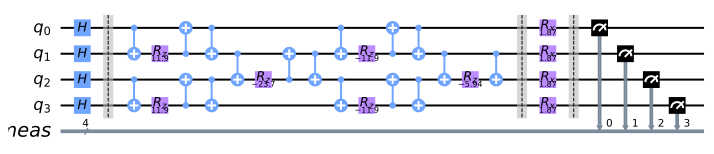

In [19]:
P, gamma, beta = 1, 2.96867277, 0.93459749
cnot_circ, initial_layout = kq.gen_complete_qaoa_circ(P, [gamma], [beta], G, ising=False, topology=rome.configuration().coupling_map)
print('Depth:', cnot_circ.depth())
print('Gates:', cnot_circ.count_ops())
print('initial_layout =', initial_layout)
cnot_circ.draw(output='mpl', fold=200, scale=0.4)

               ┌──────────┐ ░                    ┌───┐                                                       ┌───┐                               ░ ┌───────────────────────┐ ░ ┌─┐         
      q_0 -> 0 ┤ U2(0,pi) ├─░───■────────────────┤ X ├──■──────────────────────────────────■─────────────────┤ X ├──■────────────────────────────░─┤ U3(1.8692,-pi/2,pi/2) ├─░─┤M├─────────
               ├──────────┤ ░ ┌─┴─┐┌────────────┐└─┬─┘┌─┴─┐                    ┌───┐     ┌─┴─┐┌─────────────┐└─┬─┘┌─┴─┐                          ░ ├───────────────────────┤ ░ └╥┘┌─┐      
      q_1 -> 1 ┤ U2(0,pi) ├─░─┤ X ├┤ U1(11.875) ├──■──┤ X ├──■─────────────────┤ X ├──■──┤ X ├┤ U1(-11.875) ├──■──┤ X ├──■───────────────────■───░─┤ U3(1.8692,-pi/2,pi/2) ├─░──╫─┤M├──────
               ├──────────┤ ░ └───┘└────────────┘┌───┐└───┘┌─┴─┐┌─────────────┐└─┬─┘┌─┴─┐└───┘└─────────────┘┌───┐└───┘┌─┴─┐┌─────────────┐┌─┴─┐ ░ ├───────────────────────┤ ░  ║ └╥┘┌─┐   
      q_2 -> 2 ┤ U2(0,pi) ├─░───■────────────────┤ X ├──■──┤

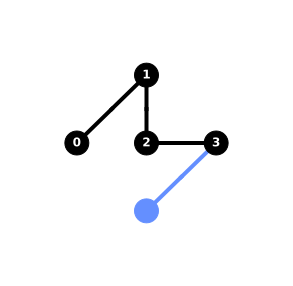

In [20]:
rome_cnots = transpile(cnot_circ, rome, optimization_level=3, initial_layout=initial_layout)
print(rome_cnots.draw(output='text', fold=200))
print('Depth:', rome_cnots.depth())
print('Gates:', rome_cnots.count_ops())
plot_circuit_layout(rome_cnots, rome)

# Run on device

## Simulator

In [21]:
# simulator
shots = 8192
noise_model = noise.device.basic_device_noise_model(rome.properties())
basis_gates = rome.configuration().basis_gates
rome_result = execute(rome_cnots, qasm_simulator, basis_gates=basis_gates, shots=shots, noise_model=noise_model,
                      coupling_map=rome.configuration().coupling_map, backend_properties=rome.properties()).result()
exact_results = execute(rome_cnots, qasm_simulator, shots=shots).result()
noisy_counts = kq.reorder_bitstrings(1, 4, rome_result.get_counts(rome_cnots))
noiseless_counts = kq.reorder_bitstrings(1, 4, exact_results.get_counts(rome_cnots))

/Users/teague/ResearchWorkspace/coresets/coresetEnv/lib/python3.7/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:112: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  DeprecationWarning)


mu_plus: [-1.5  0. ]
mu_minus: [1.5 0. ]


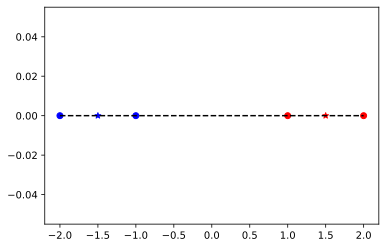

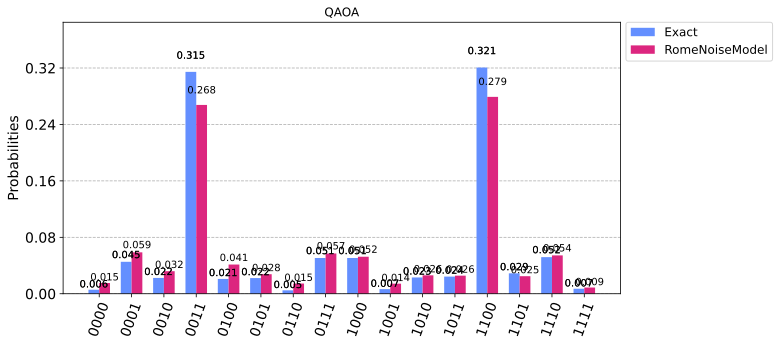

In [23]:
kq.plot_partition('1100', coreset_points)
plot_histogram([noiseless_counts, noisy_counts], figsize=(10,5), legend=['Exact', 'RomeNoiseModel'], title='QAOA')

In [24]:
# generate an energy landscape using noisy simulation
P = 1
step_size = 0.1
shots = 8192
gammaLim = [0,1.5*np.pi]
betaLim = [0,1.5*np.pi]
estC, bitstrings = kq.energy_landscape(P, step_size, shots, gammaLim, betaLim, G,
                                       device_topology=rome.configuration().coupling_map,
                                       device=rome)

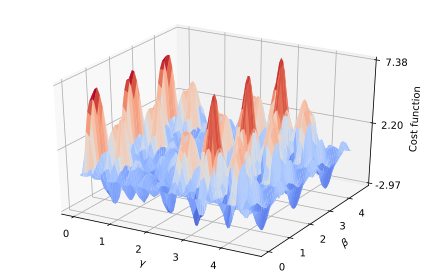


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value (avg over 8192 shots) is:  C = 7.375
This is attained for gamma = 2.100 and beta = 3.300
The 4 most common partitionings produced at this point were:
0000: 12.45% (-5), 0110: 11.76% (-5), 1001: 11.00% (-5), 1100: 10.47% (13)
mu_plus: nan
mu_minus: [0. 0.]


/Users/teague/ResearchWorkspace/coresets/kmeans_qaoa.py:470: RuntimeWarning: invalid value encountered in double_scalars
  mu_plus = np.sum([point[0]*point[1] for point in S_plus], axis=0) / np.sum([point[0] for point in S_plus])


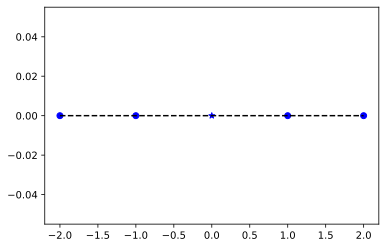

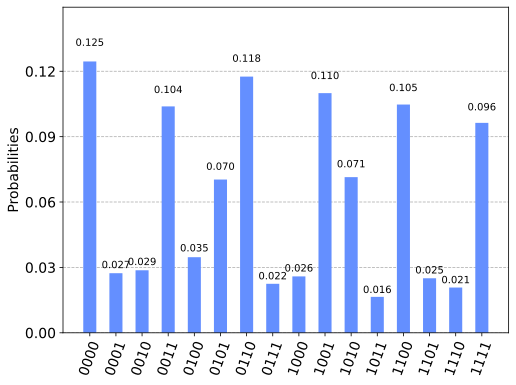

In [25]:
opt_counts = kq.plot_energy_landscape(step_size, gammaLim, betaLim, estC, bitstrings, shots, coreset_points, G, savefigs='noisy')
plot_histogram(opt_counts, figsize=(8,6))

## Hardware Execution

In [26]:
print(rome.name())
d = datetime.datetime.today()
print(d.strftime('%m-%d-%Y-%H%M'))

ibmq_rome
04-28-2020-1659


In [6]:
shots = 8192
P = 1
gamma = 3.29495934
beta = 0.49129944
noise_model = NoiseModel.from_backend(rome)
basis_gates = rome.configuration().basis_gates
coupling_map= rome.configuration().coupling_map
props = rome.properties()

In [8]:
rome_circuit, initial_layout = kq.gen_complete_qaoa_circ(P, [gamma], [beta], G, ising=False, topology=rome.configuration().coupling_map)
print(initial_layout)
initial_layout = [1,2,3,4]
print(initial_layout)

[0 1 2 3]
[1, 2, 3, 4]


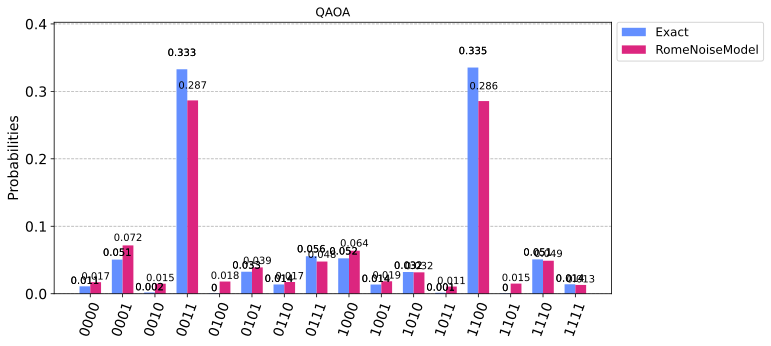

In [9]:
noisy_result = execute(rome_circuit, qasm_simulator, basis_gates=basis_gates, shots=shots, noise_model=noise_model,
                      coupling_map=coupling_map, backend_properties=props, initial_layout=initial_layout).result()
noiseless_results = execute(rome_circuit, qasm_simulator, shots=shots).result()

noisy_counts = kq.reorder_bitstrings(P, len(G.nodes), noisy_result.get_counts())
noiseless_counts = kq.reorder_bitstrings(P, len(G.nodes), noiseless_results.get_counts())
plot_histogram([noiseless_counts, noisy_counts], figsize=(10,5), legend=['Exact', 'RomeNoiseModel'], title='QAOA')

In [10]:
rome_job = execute(rome_circuit, backend=rome, shots=shots, initial_layout=initial_layout)
job_monitor(rome_job)
rome_counts = kq.reorder_bitstrings(P, len(G.nodes), rome_job.result().get_counts())

Job Status: job has successfully run


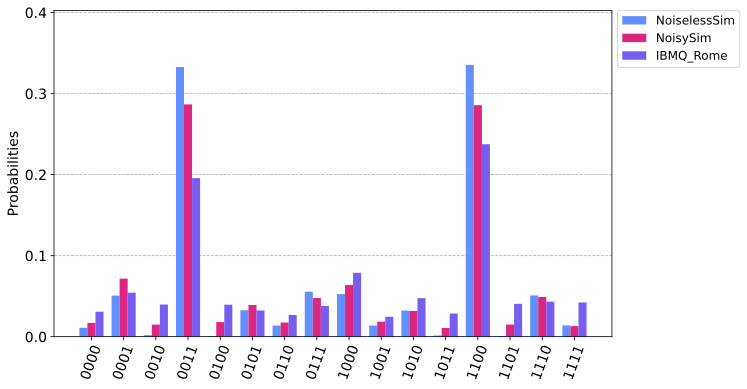

In [11]:
plot_histogram([noiseless_counts, noisy_counts, rome_counts], figsize=(10, 6), legend=['NoiselessSim', 'NoisySim', 'IBMQ_Rome'], bar_labels=False)
#fig = plot_histogram([noiseless_counts, noisy_counts, rome_counts], figsize=(10, 6), legend=['NoiselessSim', 'NoisySim', 'IBMQ_Rome'], bar_labels=False)
#fig.set_tight_layout(True)
#fig.savefig('kmeans_qaoa1.pdf')

## Energy Landscape

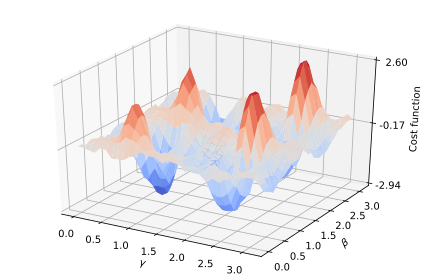


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value (avg over 8192 shots) is:  C = 2.599
This is attained for gamma = 2.700 and beta = 2.400
The 4 most common partitionings produced at this point were:
1111: 11.19%, 0010: 10.16%, 0100: 8.75%, 1000: 8.34%
mu_plus: [0. 0.]
mu_minus: nan


/Users/teague/ResearchWorkspace/coresets/kmeans_qaoa.py:462: RuntimeWarning: invalid value encountered in double_scalars
  mu_minus = np.sum([point[0]*point[1] for point in S_minus], axis=0) / np.sum([point[0] for point in S_minus])


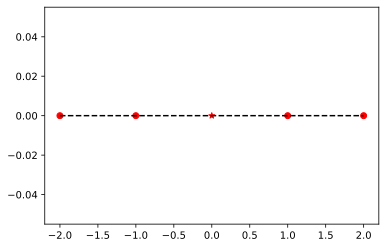

In [10]:
fullrun = kq.load_fullrun('HardwareRunPickles/ibmq_rome_04-27-2020-2156_fullrun.pickle')
gammaLim = [0,np.pi]
betaLim = [0,np.pi]
stepsize = 0.1
shots = 8192
estC = kq.compute_C_from_fullrun(fullrun, gammaLim, betaLim, stepsize, G, shots)
kq.plot_energy_landscape(stepsize, gammaLim, betaLim, estC, fullrun, shots,
                      coreset_points, savefigs='imbq_rome')

# IBM Cu1 gate
Test the Ising gate implementation for cost evolution

In [12]:
backend = Aer.get_backend('unitary_simulator')
np.set_printoptions(precision=3)

In [13]:
# The exact operator (e^(-iZZ))
I = np.identity(2)
X = np.array([[0,1],[1,0]], dtype='complex64')
Y = np.array([[0,0-1j],[0+1j,0]], dtype='complex64')
Z = np.array([[1,0],[0,-1]], dtype='complex64')
Pdict = {'I':I, 'X':X, 'Y':Y, 'Z':Z}

Hmatrix = 0
Hamiltonian = [(1,'ZZ')]
for term in Hamiltonian:
    coef, pauli_str = term
    term_matrix = 1
    for P in pauli_str[::-1]:
        term_matrix = np.kron(Pdict[P], term_matrix)
    Hmatrix = Hmatrix + coef * term_matrix
U = linalg.expm((0-1j) * Hmatrix)
Uop = Operator(U)
print(Uop.is_unitary())

exact_circ = QuantumCircuit(2)
exact_circ.append(Uop, [0, 1])
print(exact_circ)
exact_job = execute(exact_circ, backend)
exact_unitary = exact_job.result().get_unitary(exact_circ, decimals=3)
print(exact_unitary)

True
     ┌──────────┐
q_0: ┤0         ├
     │  Unitary │
q_1: ┤1         ├
     └──────────┘
[[0.54-0.841j 0.  +0.j    0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.54+0.841j 0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54+0.841j 0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    0.54-0.841j]]


In [14]:
# Implement the operator with CNOTs
phi = 1
cnot_circ = QuantumCircuit(2)
cnot_circ.cx(0,1)
cnot_circ.rz(2*phi, 1)
cnot_circ.cx(0,1)
print(cnot_circ)
cnot_job = execute(cnot_circ, backend)
cnot_unitary = cnot_job.result().get_unitary(cnot_circ, decimals=3)
print(cnot_unitary)
# The Rz gate matrix is off from the exact Rz rotation by global phase e^(-i phi)
cnot_w_phase = np.exp((0-1j) * phi) * cnot_unitary
print(cnot_w_phase)

                        
q_0: ──■─────────────■──
     ┌─┴─┐┌───────┐┌─┴─┐
q_1: ┤ X ├┤ Rz(2) ├┤ X ├
     └───┘└───────┘└───┘
[[ 1.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.416+0.909j  0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j    -0.416+0.909j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j   ]]
[[0.54-0.841j 0.  +0.j    0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.54+0.841j 0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54+0.841j 0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    0.54-0.841j]]


In [15]:
# Implement the operator with Ising type gates
ising_circ = QuantumCircuit(2)
ising_circ.cu1(-4*phi, 0, 1)
ising_circ.u1(2*phi, 0)
ising_circ.u1(2*phi, 1)
print(ising_circ)
ising_job = execute(ising_circ, backend)
ising_unitary = ising_job.result().get_unitary(ising_circ, decimals=3)
print(ising_unitary)
# The Rz gate matrix is off from the exact Rz rotation by global phase e^(-i phi)
ising_w_phase = np.exp((0-1j) * phi) * ising_unitary
print(ising_w_phase)

          ┌───────┐
q_0: ─■───┤ U1(2) ├
      │-4 ├───────┤
q_1: ─■───┤ U1(2) ├
          └───────┘
[[ 1.   +0.j     0.   +0.j     0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j    -0.416+0.909j  0.   +0.j     0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j    -0.416+0.909j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j   ]]
[[0.54-0.841j 0.  +0.j    0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.54+0.841j 0.  +0.j    0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.54+0.841j 0.  +0.j   ]
 [0.  +0.j    0.  +0.j    0.  +0.j    0.54-0.841j]]


# Experimenting with other coresets

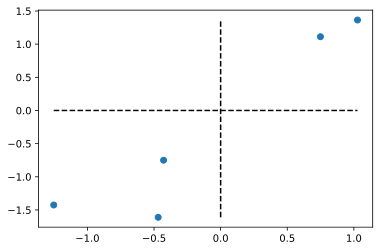

The corresponding problem Hamiltonian is:
H = 1.4ZZIII + 1.6ZIZII + -1.5ZIIZI + -1.2ZIIIZ + 2.9IZZII + -2.7IZIZI + -2.1IZIIZ + -3.2IIZZI + -2.5IIZIZ + 2.3IIIZZ 


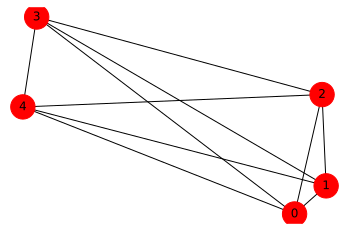

In [12]:
#coreset = [(1, np.array([-2,0])), (1, np.array([-1,0])), (1, np.array([1,0])), (1, np.array([2,0]))]
coreset = None
coreset_points, G, H = kq.gen_coreset_graph(coreset=coreset, metric='dot')
#coreset_points2, G_dist, H2 = kq.gen_coreset_graph(coreset=coreset, metric='dist')
kq.plot_coreset_graph(coreset_points, G)
hstr = ''
for term in H:
    hstr += '{:.1f}{} + '.format(term[0], ''.join(term[1]))
hstr = hstr[:-2]
print('The corresponding problem Hamiltonian is:\nH = {}'.format(hstr))

In [21]:
IBMQ.save_account('Ie2oC8#2zsIB0ke', overwrite=True)

In [25]:
IBMQ.providers()

[]

In [24]:
provider = IBMQ.enable_account('Ie2oC8#2zsIB0ke')

RequestsApiError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [19]:
IBMQ.update_account()

Found 1 credentials.
No credentials available for updating could be found. No action will be performed.
Warnings:
The stored account with url "https://auth.quantum-computing.ibm.com/api" is already an IBM Q Experience v2 account.


In [26]:
provider = IBMQ.load_account()

RequestsApiError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [ ]:
backends = provider.backends()
for b in backends: print(b)

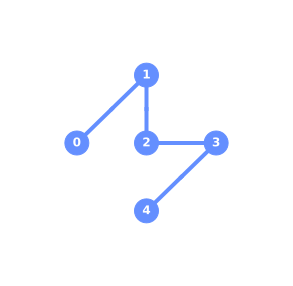

In [14]:
shots = 8192
P = 1
device = provider.get_backend('ibmq_rome')
noise_model = NoiseModel.from_backend(device)
basis_gates = device.configuration().basis_gates
coupling_map= device.configuration().coupling_map
props = device.properties()
plot_gate_map(device)

In [40]:
num_params = 2
init_params = None
opt_params, opt_cost = kq.optimize_qaoa(init_params, num_params, shots, P, G, coupling_map, device=device)

Current iteration: 0, Num function calls: 3, best so far: -7.7722902            
Current iteration: 1, Num function calls: 7, best so far: -7.7722902            
Current iteration: 2, Num function calls: 9, best so far: -7.7722902            
Current iteration: 3, Num function calls: 11, best so far: -7.7722902            
Current iteration: 4, Num function calls: 15, best so far: -7.7722902            
Current iteration: 5, Num function calls: 17, best so far: -12.1331124            
Current iteration: 6, Num function calls: 21, best so far: -12.1331124            
Current iteration: 7, Num function calls: 25, best so far: -12.1331124            
Current iteration: 8, Num function calls: 27, best so far: -14.5859339            
Current iteration: 9, Num function calls: 28, best so far: -14.5859339            
Current iteration: 10, Num function calls: 32, best so far: -15.4468352            
Current iteration: 11, Num function calls: 34, best so far: -15.4468352            
Current it

In [41]:
gamma, beta = opt_params

In [53]:
circuit, initial_layout = kq.gen_complete_qaoa_circ(P, [gamma], [beta], G, ising=False, topology=device.configuration().coupling_map)
print(initial_layout)

[0 1 2 3 4]


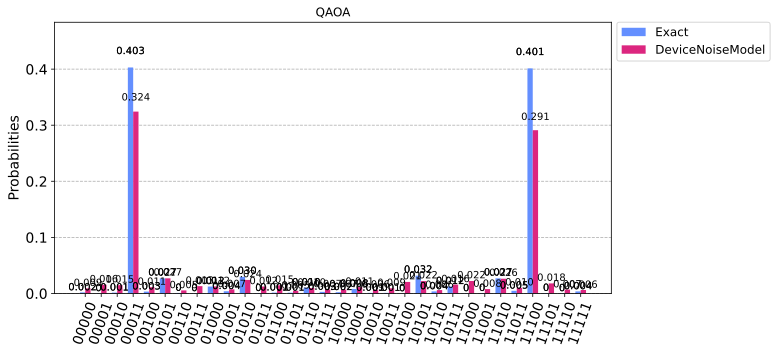

In [43]:
noisy_result = execute(circuit, qasm_simulator, basis_gates=basis_gates, shots=shots, noise_model=noise_model,
                      coupling_map=coupling_map, backend_properties=props).result()
noiseless_results = execute(circuit, qasm_simulator, shots=shots).result()

noisy_counts = kq.reorder_bitstrings(P, len(G.nodes), noisy_result.get_counts())
noiseless_counts = kq.reorder_bitstrings(P, len(G.nodes), noiseless_results.get_counts())
plot_histogram([noiseless_counts, noisy_counts], figsize=(10,5), legend=['Exact', 'DeviceNoiseModel'], title='QAOA')

mu_plus: [1.02754996 1.25591814]
mu_minus: [-1.24992484 -1.02108899]


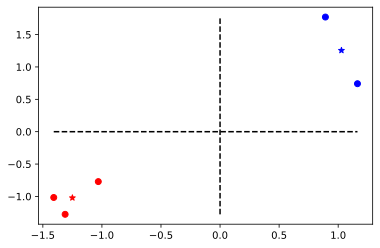

In [44]:
kq.plot_partition('00011', coreset_points)

In [46]:
qpu_job = execute(circuit, backend=device, shots=shots, initial_layout=initial_layout)
job_monitor(qpu_job)
qpu_counts = kq.reorder_bitstrings(P, len(G.nodes), qpu_job.result().get_counts())

Job Status: job has successfully run


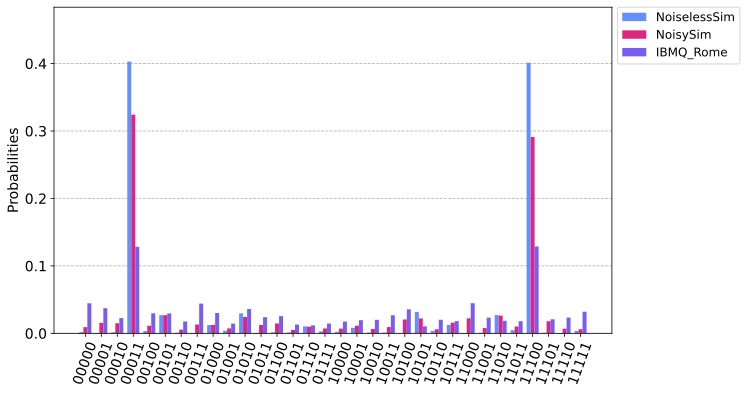

In [52]:
plot_histogram([noiseless_counts, noisy_counts, qpu_counts], figsize=(10, 6), legend=['NoiselessSim', 'NoisySim', 'IBMQ_Rome'], bar_labels=False)
#fig = plot_histogram([noiseless_counts, noisy_counts, rome_counts], figsize=(10, 6), legend=['NoiselessSim', 'NoisySim', 'IBMQ_Rome'], bar_labels=False)
#fig.set_tight_layout(True)
#fig.savefig('kmeans_qaoa2.png')